# **COMP3670/6670 Assignment 3 - GMM**
---

**Enter Your Student ID:** u7351505

**Your Name:** Yifan Luo
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- <Enter ID 1>
- <Enter ID 2>
- <Enter ID 3>
    

**Programming Section**
- 1 = 20%
- 2 = 20%
- 3 = 20%
- 4 = 10%
- 5 = 10%
- 6 = 20%

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import functools

We're going to implement an algorithm to model data with a mixture of gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional gaussian components involved, as well as their means.

Not only this, but the "distance" of each of your data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

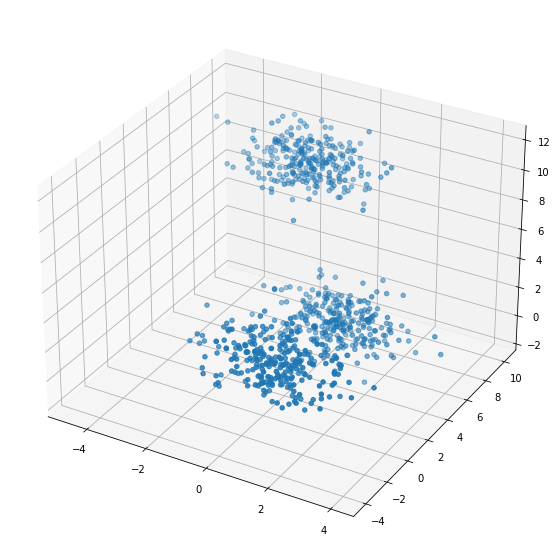

In [2]:
X = np.load("./data.npy")  # 800 * 3
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 3 dimensions. They are represented by a three dimensional Gaussian Mixture Model.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilies, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

---

In [3]:
np.random.seed(42)


def initialise_parameters(X, K):
    # YOUR CODE HERE
    # X: N * M
    sigma = np.array([np.cov(X.T) for _ in range(K)])  # K * M * M
    mu =  X[np.random.choice(range(X.shape[0]), K)]    # K * M
    pi = np.array([1 / K for _ in range(K)])           # K * 1
    return sigma, mu, pi
    
    
K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 2.08313058 -3.09054223 -3.48834796]
  [-3.09054223 15.74611592  9.01070638]
  [-3.48834796  9.01070638 11.93287373]]

 [[ 2.08313058 -3.09054223 -3.48834796]
  [-3.09054223 15.74611592  9.01070638]
  [-3.48834796  9.01070638 11.93287373]]

 [[ 2.08313058 -3.09054223 -3.48834796]
  [-3.09054223 15.74611592  9.01070638]
  [-3.48834796  9.01070638 11.93287373]]

 [[ 2.08313058 -3.09054223 -3.48834796]
  [-3.09054223 15.74611592  9.01070638]
  [-3.48834796  9.01070638 11.93287373]]]

Mu: 
 [[-1.66853863  5.49282362  8.5987521 ]
 [-0.82141525  7.25660425  8.2263065 ]
 [ 0.57404526  2.77077181  3.60151308]
 [-0.21048333  5.67604461  9.42232079]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [4]:
from scipy.stats import multivariate_normal


def E_step(pi, mu, sigma, X):
    # YOUR CODE HERE
    N, K = X.shape[0], len(pi)
    r = np.zeros((N, K))  # N * K
    for i in range(N):
        numerator = np.array([pi[j] * multivariate_normal(mu[j], sigma[j]).pdf(X[i]) for j in range(K)])
        r[i] = numerator / sum(numerator)  # K * 1
    return r


responsibilities = E_step(pi, mu, sigma, X[:, :3])  # N * K
print(responsibilities)

[[0.11796119 0.07765888 0.73328123 0.07109871]
 [0.28819669 0.42853597 0.1152337  0.16803364]
 [0.05742421 0.1924218  0.68300512 0.06714888]
 ...
 [0.07465464 0.10473335 0.64711423 0.17349778]
 [0.17234006 0.36597551 0.06996409 0.39172035]
 [0.07570853 0.21211781 0.67178075 0.04039291]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [5]:
def M_step(r, X):
    # YOUR CODE HERE
    N, M, K = X.shape[0], X.shape[1], r.shape[1]
    # update pi
    N_K = np.sum(r, axis=0)  # K * 1
    pi = N_K / N  # K * 1
    # update mu and sigma
    mu = np.zeros((K, M))
    sigma = np.zeros((K, M, M))
    for i in range(K):
        mu[i] = np.sum([r[j, i] * X[j] for j in range(N)], axis=0) / N_K[i]  # K * 1
        sigma[i] = np.sum([r[j, i] * np.outer(X[j] - mu[i], X[j] - mu[i]) for j in range(N)], axis=0) / N_K[i]  # M * M
    return mu, sigma, pi


mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 1.93033554 -4.01636599 -3.45711229]
  [-4.01636599 18.82528979 12.28889725]
  [-3.45711229 12.28889725 11.6488228 ]]

 [[ 2.03064496 -3.06049044 -3.8813895 ]
  [-3.06049044 12.28020333  9.11512301]
  [-3.8813895   9.11512301 12.72923946]]

 [[ 1.19147179 -0.79309063 -1.07752019]
  [-0.79309063 11.02745204  1.53737894]
  [-1.07752019  1.53737894  4.30041867]]

 [[ 2.10202288 -4.46757089 -3.75704734]
  [-4.46757089 19.40442777 12.48197824]
  [-3.75704734 12.48197824 11.50461916]]]

Mu: 
 [[-0.83326458  3.97989169  6.1952512 ]
 [-0.20747488  5.36694386  6.14609066]
 [ 0.84935565  2.13854837  2.67205867]
 [ 0.39327996  4.07274193  6.70040386]]

Pi: 
 [0.18931865 0.21426766 0.44186768 0.15454601]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [6]:
def classify(pi, mu, sigma, x):
    # YOUR CODE HERE
    K = len(pi)
    ps = [pi[i] * multivariate_normal(mu[i], sigma[i]).pdf(x) for i in range(K)]
    return np.argmax(ps)


print(classify(pi, mu, sigma, X[270, :3]))

2


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[ 0.95588032  0.00505882 -0.00603556]
  [ 0.00505882  1.00363664  0.02709631]
  [-0.00603556  0.02709631  0.8815131 ]]

 [[ 1.0907788  -0.13426416 -0.00661892]
  [-0.13426416  0.92850082  0.07239302]
  [-0.00661892  0.07239302  0.89267635]]

 [[ 0.88084872  0.05723987 -0.02382201]
  [ 0.05723987  1.00251614 -0.01567987]
  [-0.02382201 -0.01567987  1.04316265]]]

Mu: 
 [[-1.25357656  7.775087    9.36231957]
 [ 0.91171334 -1.55016013  2.90463154]
 [ 1.03774193  4.21660208  1.86993146]]

Pi: 
 [0.33249995 0.33328693 0.33421312]


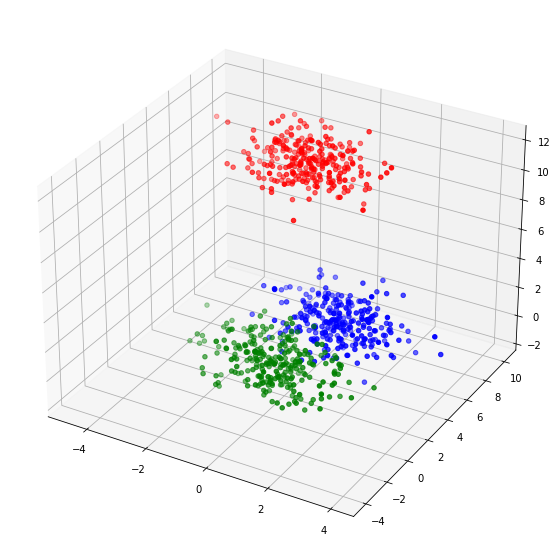

In [7]:
def EM(X, K, iterations):
    # YOUR CODE HERE
    sigma, mu, pi = initialise_parameters(X, K)
    for _ in range(iterations):
        r = E_step(pi, mu, sigma, X)
        mu, sigma, pi = M_step(r, X)
    return mu, sigma, pi


#Test code. Leave it aloooooone!
iterations = 30
K = 3
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()

---
**Task 6**: Image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics. In this task, we are going to implement a simple image segmentation algorithm using GMM. 

The *image_segmentation* function should satisfy the following specifications:
* Inputs:
    - image: the image to be segmented. Type: np.ndarray
    - K: the number of gaussians.
    - iterations: the number of iterations of EM algorithm.
* Return:
    - a matrix, each element of this matrix corresponds to the class of pixels of the input image matrix. Type: np.ndarray. dtype: np.int32.
    - For an image with shape (78,78,3), the shape of returned matrix should be (78,78).

Make sure your code can run within 3 mins.

**Read more:** https://en.wikipedia.org/wiki/Image_segmentation

**Hints:** Remember to use the functions you defined above.

---

Let's load the image to be segmented first.

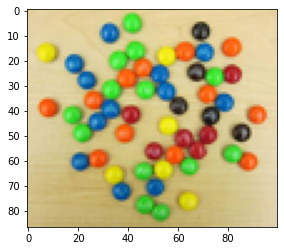

In [8]:
image = plt.imread('mandm.png')
plt.imshow(image)
plt.show()

In [ ]:
def image_segmentation(image, K=5, iterations=10):
    X = image.reshape(-1, 3)  # reshape from N * M * 3 to NM * 3
    mu, sigma, pi = EM(X, K, iterations)
    clusters = []
    for x in X:
        clusters.append(classify(pi, mu, sigma, x))
    return np.array(clusters).reshape(image.shape[0], image.shape[1])


# test code, leave it alone!
import time
start = time.time()
gmm_labels = image_segmentation(image, 5, 10)
end = time.time()
print(f'It takes {end-start} seconds to segement the image.')
colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]
segemented_image = np.zeros_like(image, dtype=np.int32)
m, n, _ = segemented_image.shape
for i in range(m):
    for j in range(n):
        segemented_image[i, j] = np.array(colors[gmm_labels[i, j]])
plt.imshow(segemented_image)
plt.show()

Your answer should look like this, maybe with different colors:
![image](./segmented_image.png)